In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from itertools import combinations
import graphviz

In this study we will be looking at drug overdoses in the city of connecticut.  We will be training a logitic Reggression classifier and a Decision Tree to take gueusses on if a personoverdosed on a particular drug.  We will not be predicting combinations of drugs so each drug will be a seprate classifier. 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/7r3y70dd/dataSheets/refs/heads/main/Accidental_Drug_Related_Deaths_2012-2018.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5105 entries, 0 to 5104
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5105 non-null   object 
 1   Date                 5103 non-null   object 
 2   DateType             5103 non-null   object 
 3   Age                  5102 non-null   float64
 4   Sex                  5099 non-null   object 
 5   Race                 5092 non-null   object 
 6   ResidenceCity        4932 non-null   object 
 7   ResidenceCounty      4308 non-null   object 
 8   ResidenceState       3556 non-null   object 
 9   DeathCity            5100 non-null   object 
 10  DeathCounty          4005 non-null   object 
 11  Location             5081 non-null   object 
 12  LocationifOther      590 non-null    object 
 13  DescriptionofInjury  4325 non-null   object 
 14  InjuryPlace          5039 non-null   object 
 15  InjuryCity           3349 non-null   o

Next we will take a look at na values for data cleaning.  All of the drug columns will have lots of na values as they were supplied as catagorical columns.  For the moment na means that the drug was not present at the time of overdose, Y means the drug was present.

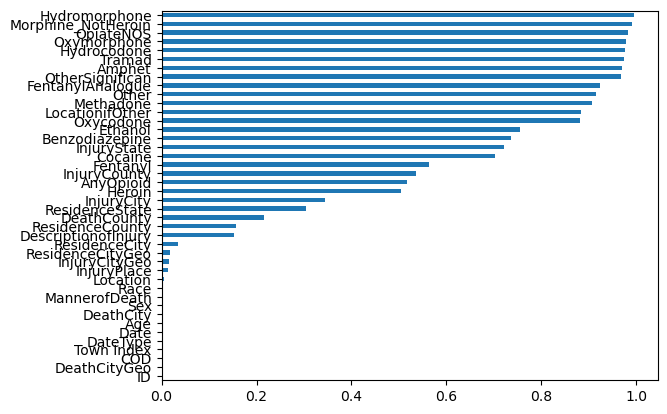

In [4]:
##### plt.figure(figsize=(6, 8))
df.isna().mean().sort_values().plot.barh();

From the graph we can see that most of the columns containing na values are the drug columns.  This is expected and means that the columns of most of our predictor varibles have values for most of the rows.  Two columns that pop out in this list are the OtherSignifcan and the LocationifOther columns.  OtherSignifcan is a list of preexisting health conditions if applicable, and Locationifother is sort of a more detailed version of the location column.  Both of these columns rarly apply as seen by the graph and also have lots of variation in values.  For these reasons we will not use these columns and others like it in our predicions.

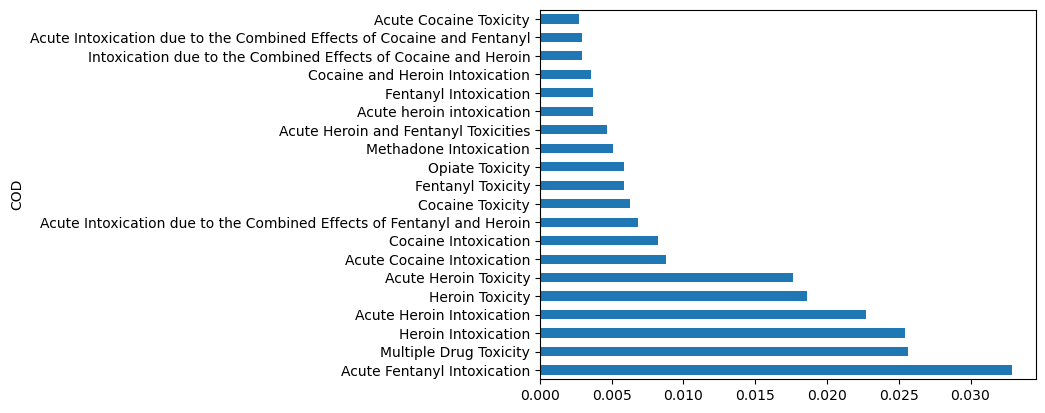

In [5]:
df['COD'].value_counts(normalize=True)[:20].plot.barh();

This casue of death column seems to mostly denote combinations of different drugs.  We will not be looking at these combbinations and thus will not use this column.

<Axes: ylabel='DeathCity'>

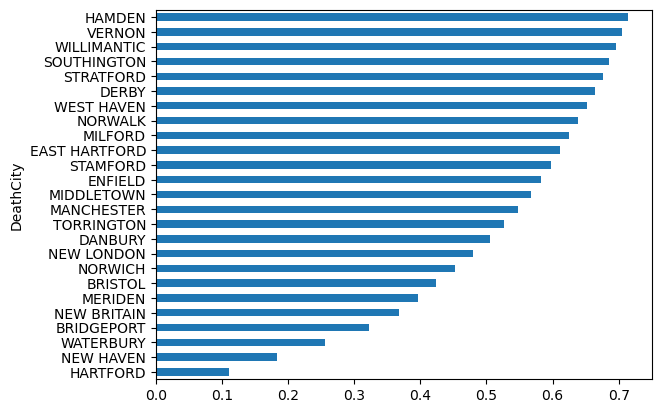

In [6]:
top25 = df['DeathCity'].value_counts(normalize=True).cumsum()[:25]
top25.plot.barh()

We will now add a column for the median income.  The top 25 columns will be populated with thier cities median income while all other cities will be filled with an overall state median.

In [7]:
def to_lowercase(df, column_name):
    df[column_name] = df[column_name].astype(str).str.lower()
    return df

In [8]:
to_lowercase(df, 'DeathCity')

city_median = {'hamden': 92176,'vernon': 82445, 'willmantic': 41972, 'southington': 118790, 'stratford': 92691, 'derby': 76263, 'norwalk': 97879, 'west haven': 73566, 'milford': 104503, 'east hartford': 66943, 'stamford': 100718, 'enfeild': 89361, 'middletown': 73979, 'manchester': 73265, 'torrington': 66616, 'danbury': 83422, 'new london': 56237, 'norwhich': 64629, 'meriden': 62411, 'new britain': 57036, 'bridgeport': 56584, 'waterbury': 51642, 'new haven': 54305, 'hartford': 45300}

df['median_income'] = df['DeathCity'].map(city_median)

df['median_income'] = df['median_income'].fillna(90213)

Here we can see the cities that appear the most often in the dataset.  To help predictions we will only include the top 25 cities.  All other cities will be combined into an 'Other' attribute.  We can see we encapculate 70 procent of the data in these top 25 cities so this should help bring down the amount of dummy columns.

In [9]:
drug_columns = [
    'Heroin', 'Cocaine', 'Fentanyl', 'FentanylAnalogue', 'Oxycodone', 
    'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone',
    'Amphet', 'Tramad', 'Morphine_NotHeroin', 'Hydromorphone',
    'OpiateNOS', 'AnyOpioid'
]

for col in drug_columns:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in Heroin: [nan 'Y']
Unique values in Cocaine: [nan 'Y']
Unique values in Fentanyl: ['Y' nan 'Y-A' 'Y POPS' 'Y (PTCH)']
Unique values in FentanylAnalogue: [nan 'Y']
Unique values in Oxycodone: [nan 'Y']
Unique values in Oxymorphone: [nan 'Y']
Unique values in Ethanol: [nan 'Y']
Unique values in Hydrocodone: ['Y' nan]
Unique values in Benzodiazepine: ['Y' nan]
Unique values in Methadone: [nan 'Y']
Unique values in Amphet: [nan 'Y']
Unique values in Tramad: [nan 'Y']
Unique values in Morphine_NotHeroin: [nan 'Y' 'YES' 'STOLE MEDS' 'NO RX BUT STRAWS' 'PCP NEG']
Unique values in Hydromorphone: [nan 'Y']
Unique values in OpiateNOS: [nan 'Y']
Unique values in AnyOpioid: [nan 'Y' 'N']


Here we can see the unique values in all of the drug columns.  We will need to clean this data to use it for linear reggression.

<Axes: >

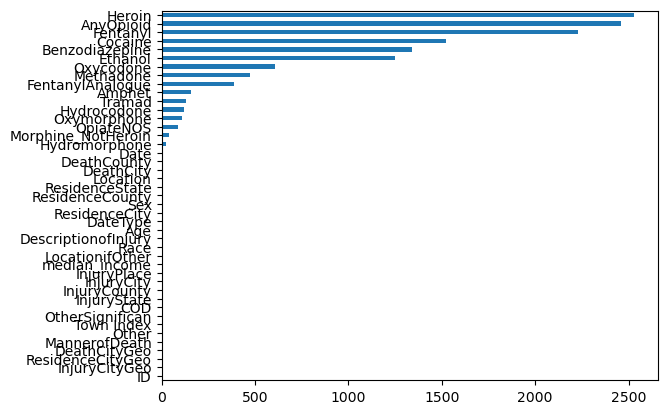

In [10]:
(df == 'Y').sum().sort_values().plot.barh()

Here we can see the different drugs that make up the dataframe.  We will be guessing the drugs that appear the most in the dataset.  Injury plsce seems like it should have some effect on drug overdoesed on so we will convert them all to lowercase to standardize the entires and reduce the amount of unique values.

In [11]:
df.apply([pd.Series.nunique, pd.Series.unique]).transpose()

,nunique,unique
ID,5105,"[14-0273, 13-0102, 16-0165, 16-0208, 13-0052, ..."
Date,2098,"[06/28/2014 12:00:00 AM, 03/21/2013 12:00:00 A..."
DateType,2,"[DateReported, DateofDeath, nan]"
Age,65,"[nan, 48.0, 30.0, 23.0, 22.0, 21.0, 40.0, 50.0..."
Sex,3,"[nan, Male, Female, Unknown]"
Race,11,"[nan, Black, White, Asian, Other, Hispanic, Wh..."
ResidenceCity,370,"[nan, NORWALK, SANDY HOOK, RYE, FLUSHING, BRIS..."
ResidenceCounty,84,"[nan, FAIRFIELD, WESTCHESTER, QUEENS, HARTFORD..."
ResidenceState,26,"[nan, CT, NY, PA, MA, FL, TN, GA, CA, ME, OK, ..."
DeathCity,223,"[nan, norwalk, danbury, greenwich, bristol, we..."


We will now Convert the data for training on a logistic regression model.

In [12]:
df['Sex'] = df['Sex'].fillna('Male')
df['ResidenceCity'] = df['ResidenceCity'].fillna('Unknown')
df['ResidenceCounty'] = df['ResidenceCounty'].fillna('Unknown')
df['ResidenceState'] = df['ResidenceState'].fillna('Unknown')
df['DeathCity'] = df['DeathCity'].fillna('Unknown')
df['DeathCounty'] = df['DeathCounty'].fillna('Unknown')
df['Location'] = df['Location'].fillna('Unknown')
# df = df.dropna(subset=['Sex', 'ResidenceCity', 'ResidenceCounty', 'ResidenceState', 
#                        'DeathCity', 'DeathCounty', 'Location'])
# df['Other'] = df['Other'].fillna('0')
cols = ['Methadone', 'Amphet', 'Tramad', 'Hydromorphone', 'OpiateNOS', 'AnyOpioid', 'Morphine_NotHeroin', 'Heroin', 'Cocaine', 'FentanylAnalogue', 'Oxycodone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Oxymorphone', 'Fentanyl']
df[cols] = df[cols].fillna(0)
# df['ResidenceState'] = df['ResidenceState'].fillna('Unknown')
df['Race'] = df['Race'].fillna('White')
df['Age'] = df['Age'].fillna(df['Age'].median())
cols = ['Methadone',   'Amphet', 'Tramad', 'Hydromorphone', 'OpiateNOS', 'Heroin', 'Cocaine', 'FentanylAnalogue', 'Oxycodone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Oxymorphone']
mapping = {'Y': 1}
df[cols] = df[cols].replace(mapping)
cols = ['Fentanyl']
mapping = {'Y': 1, 'Y-A' : 1, 'Y POPS': 1, 'Y (PTCH)': 1}
df[cols] = df[cols].replace(mapping)
cols = ['AnyOpioid']
mapping = {'N': 0, 'Y': 1}
df[cols] = df[cols].replace(mapping)
cols = ['Morphine_NotHeroin']
mapping = {'STOLE MEDS': 1, 'NO RX BUT STRAWS': 1, 'PCP NEG': 1, 'YES': 1, 'Y': 1}
df[cols] = df[cols].replace(mapping)
allowed_values = top25.index
df.loc[~df['DeathCity'].isin(allowed_values), 'DeathCity'] = 'Other'
scaler = StandardScaler()
df['median_income'] = scaler.fit_transform(df[['median_income']])
df['Age'] = scaler.fit_transform(df[['Age']])

/var/folders/zf/nq16bky57gb3bjfjhl7bctxh0000gn/T/ipykernel_29669/3667666239.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace(mapping)
/var/folders/zf/nq16bky57gb3bjfjhl7bctxh0000gn/T/ipykernel_29669/3667666239.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace(mapping)
/var/folders/zf/nq16bky57gb3bjfjhl7bctxh0000gn/T/ipykernel_29669/3667666239.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old

In [13]:
df.apply([pd.Series.nunique, pd.Series.unique]).transpose()

,nunique,unique
ID,5105,"[14-0273, 13-0102, 16-0165, 16-0208, 13-0052, ..."
Date,2098,"[06/28/2014 12:00:00 AM, 03/21/2013 12:00:00 A..."
DateType,2,"[DateReported, DateofDeath, nan]"
Age,65,"[0.0028433521596209076, 0.4893901490824158, -0..."
Sex,3,"[Male, Female, Unknown]"
Race,11,"[White, Black, Asian, Other, Hispanic, White, ..."
ResidenceCity,371,"[Unknown, NORWALK, SANDY HOOK, RYE, FLUSHING, ..."
ResidenceCounty,85,"[Unknown, FAIRFIELD, WESTCHESTER, QUEENS, HART..."
ResidenceState,27,"[Unknown, CT, NY, PA, MA, FL, TN, GA, CA, ME, ..."
DeathCity,1,[Other]


After this data cleaning we can see that all of the drug columns are full of 0 or 1 values and can now be used to train the model.

In [14]:
columns_of_interest = [
    'Heroin', 'Cocaine', 'Fentanyl', 'FentanylAnalogue', 'Oxycodone', 
    'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone', 
    'Amphet', 'Tramad', 'Morphine_NotHeroin', 'Hydromorphone'
]

means = df[columns_of_interest].mean().sort_values(ascending=False)

print(means)

Heroin                0.495397
Fentanyl              0.437218
Cocaine               0.297943
Benzodiazepine        0.263075
Ethanol               0.244270
Oxycodone             0.118903
Methadone             0.092850
FentanylAnalogue      0.076200
Amphet                0.031146
Tramad                0.025465
Hydrocodone           0.023115
Oxymorphone           0.021156
Morphine_NotHeroin    0.008227
Hydromorphone         0.004897
dtype: float64


Based on these column means we will only be predicting the top five drugs.  

In [15]:
# catagorical_data = ['Sex', 'Race', 'ResidenceCity', 'ResidenceCounty', 'ResidenceState', 'DeathCity', 'DeathCounty', 'Location', 'InjuryPlace', 'InjuryCity']
# df = pd.get_dummies(df, columns=catagorical_data, drop_first=True)

categorical_columns = ['Sex', 'Race', 'ResidenceCity', 'ResidenceCounty', 'ResidenceState', 
                       'DeathCity', 'DeathCounty', 'Location', 
                       'InjuryPlace', 'InjuryCity']

dummy_column_groups = {}

for col in categorical_columns:
    dummies = pd.get_dummies(df[col], prefix=col)
    dummy_column_groups[col] = list(dummies.columns)
    df = pd.concat([df, dummies], axis=1)

df = df.drop(columns=categorical_columns)

# print("Dummy columns for 'Sex':", dummy_column_groups['Sex'])


Here we have a function that will keep track of the names of all the dummy columns associated with the original column name.  We can use this to exclude different columns for making predictions.

In [16]:
training_default_removal = ['ID', 'Date', 'DateType', 'LocationifOther', 'DescriptionofInjury', 'InjuryCounty', 'InjuryState', 'COD', 'OtherSignifican', 'Other', 'MannerofDeath', 'DeathCityGeo', 'ResidenceCityGeo', 'InjuryCityGeo', 'Town Index', 'Heroin', 'Cocaine', 'Fentanyl', 'FentanylAnalogue', 'Oxycodone', 'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad', 'Morphine_NotHeroin', 'Hydromorphone', 'OpiateNOS', 'AnyOpioid']

# drop_dummy_groups = ['ResidenceCity', 'ResidenceCounty', 'ResidenceState', 
#                        'DeathCity', 'DeathCounty', 'Location', 
#                        'InjuryPlace', 'InjuryCity']

# dropping = []
# for group in drop_dummy_groups:
#     if group in dummy_column_groups:
#         dropping.extend(dummy_column_groups[group])

In [17]:
# X = df.drop(columns=training_default_removal)
# y = df['Heroin']

# # Drop groups and find the best combination of predictors
# drop_dummy_groups = ['ResidenceCity', 'ResidenceCounty', 'ResidenceState', 
#                      'DeathCity', 'DeathCounty', 'Location', 'InjuryPlace', 'InjuryCity', 'median_income']

# best_score = 0
# best_combination = None

# # Iterate through combinations of groups to drop
# for i in range(1, len(drop_dummy_groups) + 1):
#     for combo in combinations(drop_dummy_groups, i):
#         # Create a list of columns to drop
#         dropping = []
#         for group in combo:
#             if group in dummy_column_groups:
#                 dropping.extend(dummy_column_groups[group])
        
#         # Drop the selected columns
#         X_temp = X.drop(columns=dropping, errors='ignore')
        
#         # Split data into train and test
#         X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.3, random_state=42)
        
#         # Fit logistic regression model
#         model = LogisticRegression(class_weight='balanced', max_iter=1000)
#         model.fit(X_train, y_train)
        
#         # Evaluate using cross-validation
#         score = cross_val_score(model, X_temp, y, cv=5, scoring='accuracy').mean()

        
#         # Update the best combination
#         if score > best_score:
#             best_score = score
#             best_combination = combo

# # Print the best results
# print(f"Best Accuracy: {best_score}")
# print(f"Best Combination of Groups to Drop: {best_combination}")

Here we define the columns that we need to drop by default on every iteration of the training of the classifier.  For this example the only classifier suggested to be romoved was race and it had minimal effect on the overall accuracy.

In [18]:
X = df.drop(columns=training_default_removal)
y = df['Heroin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
regr = LogisticRegression(max_iter=1000)
regr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [20]:
y_pred = regr.predict(X_test)
y_proba = regr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.58      0.57       766
           1       0.56      0.52      0.54       766

    accuracy                           0.55      1532
   macro avg       0.55      0.55      0.55      1532
weighted avg       0.55      0.55      0.55      1532



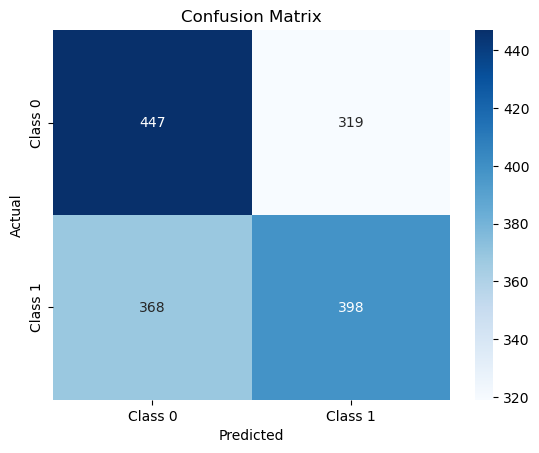

              precision    recall  f1-score   support

           0       0.55      0.58      0.57       766
           1       0.56      0.52      0.54       766

    accuracy                           0.55      1532
   macro avg       0.55      0.55      0.55      1532
weighted avg       0.55      0.55      0.55      1532



In [21]:
y_pred = regr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

THese are predictions of the presence of Heroin based on all the columns of thedataframe.  We can see that we got an overall accuracy of 55% which is barley above baseline.

In [22]:
drop_dummy_groups = ['ResidenceCity', 'ResidenceCounty', 'ResidenceState', 'DeathCity', 'InjuryPlace', 'InjuryCity']

dropping = []
for group in drop_dummy_groups:
    if group in dummy_column_groups:
        dropping.extend(dummy_column_groups[group])

X = df.drop(columns=training_default_removal + dropping)
y = df['Heroin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regr = LogisticRegression(max_iter=1000)
regr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

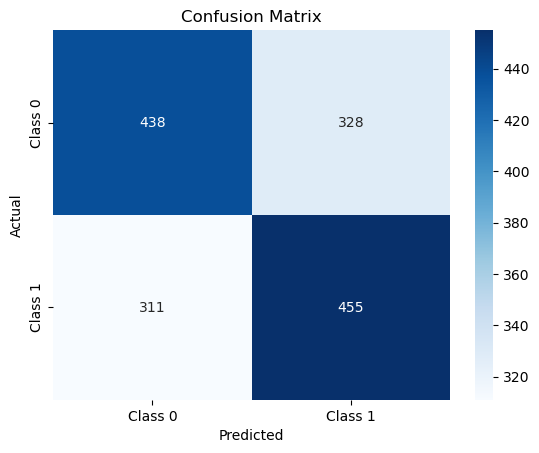

              precision    recall  f1-score   support

           0       0.58      0.57      0.58       766
           1       0.58      0.59      0.59       766

    accuracy                           0.58      1532
   macro avg       0.58      0.58      0.58      1532
weighted avg       0.58      0.58      0.58      1532



In [23]:
y_pred = regr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

By searching the combinations of predictor varibles using the function above we got the list to be dropped and gotan accuracy boost of about 3%.   THis is negligible but it is a boost in accuracy.

In [24]:
#make before and after class_weights=balanced
# cocaine all data
drop_dummy_groups = ['ResidenceCity', 'ResidenceCounty', 'ResidenceState', 'DeathCounty', 'InjuryCity']

dropping = []
for group in drop_dummy_groups:
    if group in dummy_column_groups:
        dropping.extend(dummy_column_groups[group])
        
X = df.drop(columns=training_default_removal + dropping)
y = df['Cocaine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regr = LogisticRegression(class_weight='balanced', max_iter=1000)
regr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

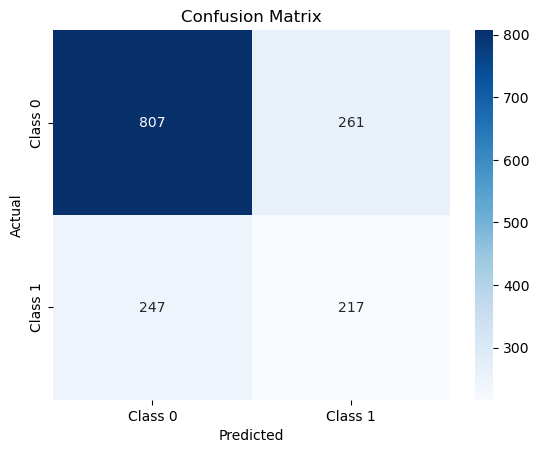

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1068
           1       0.45      0.47      0.46       464

    accuracy                           0.67      1532
   macro avg       0.61      0.61      0.61      1532
weighted avg       0.67      0.67      0.67      1532



In [25]:
y_pred = regr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

Here we have predictions for cocaine.  For this catagory we see a majority of accurate false predictions.  THis in not a good score because our true positives do not rise above our false positives or negatives.  It appearrs out model is not very good at predicting the cocaine class.  Now we will predict the accuracy of fentynal.

In [26]:
#WHOLE THING ++ all
drop_dummy_groups = ['ResidenceCity', 'ResidenceCounty']

dropping = []
for group in drop_dummy_groups:
    if group in dummy_column_groups:
        dropping.extend(dummy_column_groups[group])
        
X = df.drop(columns=training_default_removal + dropping)
y = df['Fentanyl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regr = LogisticRegression(max_iter=1000)
regr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [27]:
y_pred = regr.predict(X_test)
y_proba = regr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.74      0.73      0.73       886
           1       0.63      0.65      0.64       646

    accuracy                           0.70      1532
   macro avg       0.69      0.69      0.69      1532
weighted avg       0.70      0.70      0.70      1532



THis accuracy score is much better than the models preceding it. THis suggests that  the columns availible to usbestpredict fentynal useover any of the other drug catagories.

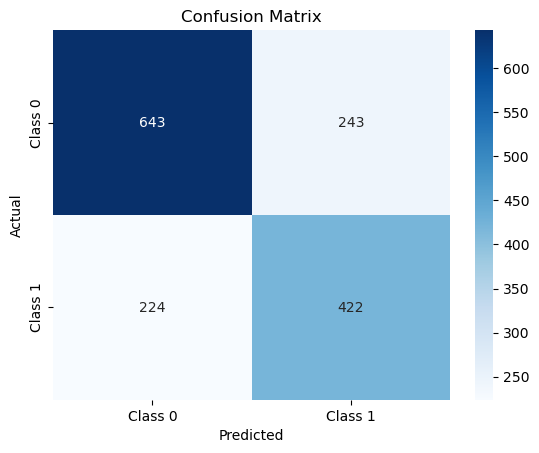

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       886
           1       0.63      0.65      0.64       646

    accuracy                           0.70      1532
   macro avg       0.69      0.69      0.69      1532
weighted avg       0.70      0.70      0.70      1532



In [28]:
y_pred = regr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

Here we can see a balanced confusion matrix.  THis meansthat the model ismaking sufficentpredictions of both calsses,and is accurate moreoften than not.

In [29]:
drop_dummy_groups = ['DeathCounty', 'Location', 'InjuryCity']

dropping = []
for group in drop_dummy_groups:
    if group in dummy_column_groups:
        dropping.extend(dummy_column_groups[group])
        
X = df.drop(columns=training_default_removal+ dropping)
y = df['Benzodiazepine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regr = LogisticRegression(class_weight='balanced', max_iter=1000)
regr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

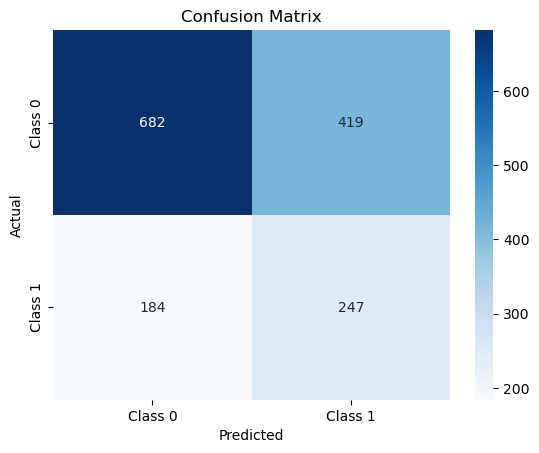

              precision    recall  f1-score   support

           0       0.79      0.62      0.69      1101
           1       0.37      0.57      0.45       431

    accuracy                           0.61      1532
   macro avg       0.58      0.60      0.57      1532
weighted avg       0.67      0.61      0.63      1532



In [30]:
y_pred = regr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

Here is the confusion matrix for the benzo catagory.  We can see that out classifier is swaying towards the false class. Even the amount of false positives  outway the true positives.

In [31]:
X = df.drop(columns=training_default_removal)
y = df['Ethanol']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regr = LogisticRegression(class_weight='balanced', max_iter=1000)
regr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

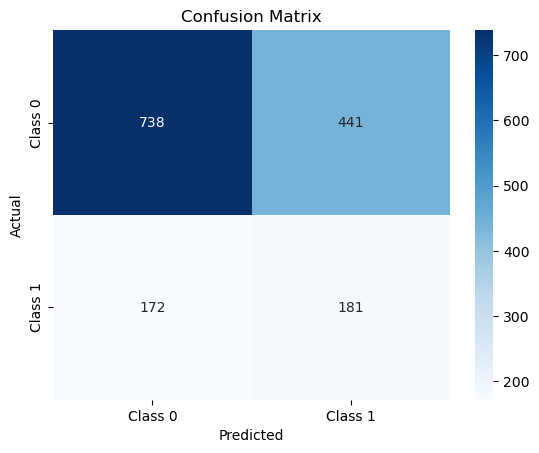

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1179
           1       0.29      0.51      0.37       353

    accuracy                           0.60      1532
   macro avg       0.55      0.57      0.54      1532
weighted avg       0.69      0.60      0.63      1532



In [32]:
y_pred = regr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

FOr the ethonal catagory we see a similar result to the benzo catagory.  As we go down the list of drug columns by number of ooverdoses the model accuracy is not likly to improve.

In [33]:
param_grid = {
    'max_depth': range(5, 15),
    'min_samples_leaf': [50, 75, 100, 200, 400, 800, 1200],
    'max_features': ['sqrt','log2', None]
}

tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10)


tree_cv.fit(X_train, y_train)

NameError: name 'clf' is not defined

Here is a grid search in order to find the best hyperparameters for the logistic classifier.  These will be usedlater  in order to get the best accuracy possible.

In [ ]:
X = df.drop(columns=training_default_removal)
y = df['Fentanyl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, max_features=None, min_samples_leaf=80)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [ ]:
# selected, accuracies = forward_selection_classif(clf, X_train, y_train, num_folds=10)
# plot_selected(selected[:10], accuracies[:10], np.array(predictors))

We have now trained our decision tree and will see it graphed below.

In [ ]:
def plot_tree_custom(clf, feature_names, class_names):
    """ Plot a Titanic classification tree using Graphviz. """

    dot_data = export_graphviz(clf, precision=2,
                         feature_names=feature_names,
                         proportion=True,
                         class_names=class_names,
                         filled=True, rounded=True,
                         special_characters=True)

    # plot it
    graph = graphviz.Source(dot_data)
    return graph

In [ ]:
plot_tree_custom(clf, feature_names=df.drop(columns=training_default_removal).columns, class_names=['True', 'False'])

In [ ]:
importances = clf.feature_importances_

feature_names = df.drop(columns=training_default_removal).columns

indices = np.argsort(importances)[::-1]

top10_indices = indices[:10]
top10_importances = importances[top10_indices]
top10_features = [feature_names[i] for i in top10_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(10), top10_importances[::-1], align='center')
plt.yticks(range(10), top10_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features in the Decision Tree")
plt.tight_layout()
plt.show()

This decision tree gives us a clearer picture about which varibles have the most effect on the prediction.

In [ ]:
X = df.drop(columns=training_default_removal)
y = df['Cocaine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = DecisionTreeClassifier(max_depth=10, max_features=None, min_samples_leaf=80)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
importances = clf.feature_importances_

feature_names = df.drop(columns=training_default_removal).columns

indices = np.argsort(importances)[::-1]

# Select the top 10 features
top10_indices = indices[:10]
top10_importances = importances[top10_indices]
top10_features = [feature_names[i] for i in top10_indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(10), top10_importances[::-1], align='center')
plt.yticks(range(10), top10_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features in the Decision Tree")
plt.tight_layout()
plt.show()

An interesting note is that Race shot to the top of important coeficients when switching the targetvarible to cocaine.

In [ ]:
plot_tree_custom(clf, feature_names=df.drop(columns=training_default_removal).columns, class_names=['True', 'False'])

In [ ]:
X = df.drop(columns=training_default_removal)
y = df['Heroin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = DecisionTreeClassifier(max_depth=10, max_features=None, min_samples_leaf=80)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
plot_tree_custom(clf, feature_names=df.drop(columns=training_default_removal).columns, class_names=['True', 'False'])
importances = clf.feature_importances_

feature_names = df.drop(columns=training_default_removal).columns

indices = np.argsort(importances)[::-1]

top10_indices = indices[:10]
top10_importances = importances[top10_indices]
top10_features = [feature_names[i] for i in top10_indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(10), top10_importances[::-1], align='center')
plt.yticks(range(10), top10_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features in the Decision Tree")
plt.tight_layout()
plt.show()

Above are the coefficient importances for heroin.

In [ ]:
plot_tree_custom(clf, feature_names=df.drop(columns=training_default_removal).columns, class_names=['True', 'False'])

In [ ]:
X = df.drop(columns=training_default_removal)
y = df['Benzodiazepine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = DecisionTreeClassifier(max_depth=10, max_features=None, min_samples_leaf=80)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
plot_tree_custom(clf, feature_names=df.drop(columns=training_default_removal).columns, class_names=['True', 'False'])
importances = clf.feature_importances_

feature_names = df.drop(columns=training_default_removal).columns

indices = np.argsort(importances)[::-1]

top10_indices = indices[:10]
top10_importances = importances[top10_indices]
top10_features = [feature_names[i] for i in top10_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(10), top10_importances[::-1], align='center')
plt.yticks(range(10), top10_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features in the Decision Tree")
plt.tight_layout()
plt.show()

And finally for our last drug we have benzos

In [ ]:
plot_tree_custom(clf, feature_names=df.drop(columns=training_default_removal).columns, class_names=['True', 'False'])

In conclusion we can glean about a 70% accuracy rate when it comes to predicting overdddose in the state of conecticut.  Our algorithims always preformed best on fentynal rather than the other drugs.  I find this particularly interesting because it is not the majority class. Heroin is the majority classand it seems to be the worst preforming of all of the columns.